In [108]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [109]:
basepath = os.path.expanduser('../')

## Load Data

In [110]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 29.2 ms, sys: 35 ms, total: 64.3 ms
Wall time: 1.22 s


### Utilisation rate

Ratio of total balance to credit limit where the value of utilisation rate should be between 0 and 1. However, there are cases when this rate goes below or over the standard range. For example, customers overpay their loans (i.e.utilization rate < 0) or the total balance exceeds the credit limit (i.e. bal > credit limit).

In [20]:
mask = (credit_bal.MONTHS_BALANCE >= -6) & (credit_bal.MONTHS_BALANCE <= -1) & (credit_bal.NAME_CONTRACT_STATUS == 'Active')
tmp  = credit_bal.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]

res  = (tmp.AMT_BALANCE / tmp.AMT_CREDIT_LIMIT_ACTUAL).replace([np.inf, -np.inf], np.nan)
res  = res.groupby(tmp.SK_ID_CURR).median()
res  = app_train.SK_ID_CURR.map(res)

In [21]:
# percentage of missing values
res[res.isnull()].shape[0] / len(res)

0.787591338196032

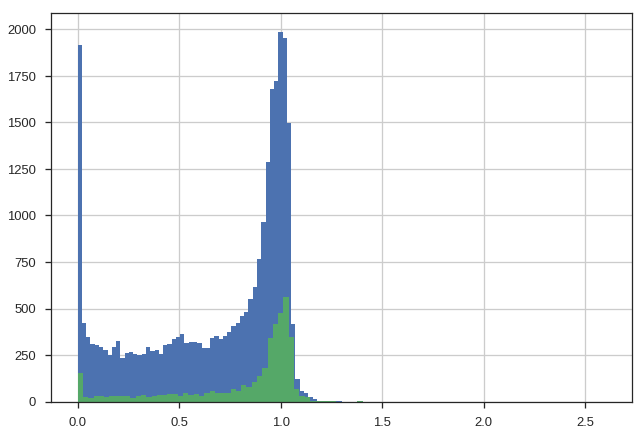

In [22]:
res[(res > 0) & (res < 6) & (app_train.TARGET == 0)].hist(bins=100)
res[(res > 0) & (res < 6) & (app_train.TARGET == 1)].hist(bins=100);

In [19]:
credit_bal.loc[(credit_bal.NAME_CONTRACT_STATUS == 'Signed'), ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]\
          .sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
3251284,100047,1472630,-39,0.000000,450000
2465501,100100,1595956,-94,37714.500000,90000
2629875,100100,1595956,-93,70564.500000,90000
2289044,100100,1595956,-92,67414.500000,90000
2204833,100170,2253989,-8,46570.500000,337500
3744613,100260,2341414,-84,0.000000,180000
1366882,100266,2801383,-40,337206.687500,360000
1582125,100338,1298559,-24,0.000000,180000
2437542,100362,2445990,-80,0.000000,180000
1019390,100414,1026684,-83,47583.000000,45000


In [12]:
credit_bal.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

### Repayments

Num times client was unable to repay what was required of him.

In [26]:
pc = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV']]
pc = pc.merge(installments.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_INSTALMENT', 'AMT_PAYMENT', 'NUM_INSTALMENT_NUMBER']], how='left')

In [27]:
pc.loc[:, 'diff_inst_payment'] = (pc.AMT_INSTALMENT - pc.AMT_PAYMENT).astype(np.float32)
pc.loc[:, 'neg_inst_payment']  = (pc.diff_inst_payment > 0).astype(np.int8)

res = pc.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['neg_inst_payment'].sum().drop('SK_ID_PREV', axis=1)
res = res.groupby('SK_ID_CURR')['neg_inst_payment'].sum()
res = app_train.SK_ID_CURR.map(res)

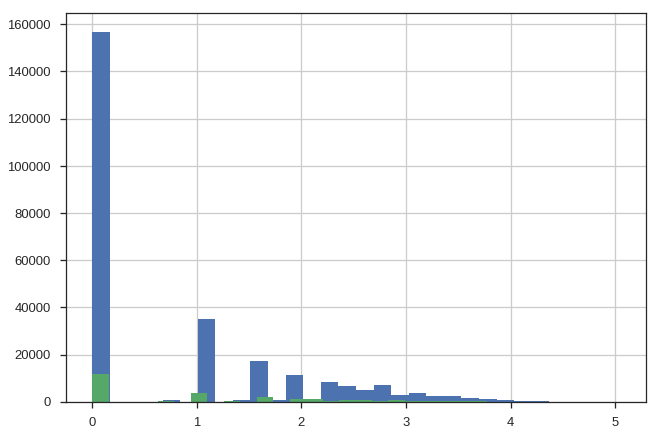

In [34]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=30)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=30);

In [28]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET         0.0    1.0     ratio
SK_ID_CURR                         
0.0         156941  11918  0.070580
1.0            620     91  0.127989
2.0          35045   3506  0.090944
3.0            788    100  0.112613
4.0          17383   1864  0.096846
5.0            725     78  0.097136
6.0          11275   1235  0.098721
7.0            719    100  0.122100
8.0           7953    933  0.104997
9.0            572    104  0.153846
10.0          6096    661  0.097824
11.0           544     77  0.123994
12.0          4629    501  0.097661
13.0           466     63  0.119093
14.0          3640    406  0.100346
15.0           401     54  0.118681
16.0          2929    351  0.107012
17.0           385     41  0.096244
18.0          2305    256  0.099961
19.0           316     48  0.131868
20.0          1903    179  0.085975
21.0           271     40  0.128617
22.0          1473    154  0.094653
23.0           231     39  0.144444
24.0          1213    137  0.101481
25.0           197     37  0

### Repayments in a timely fashion

In [20]:
tmp = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV']]
tmp = tmp.merge(installments, how='left')

t = (tmp.DAYS_INSTALMENT - tmp.DAYS_ENTRY_PAYMENT)
p = (tmp.AMT_INSTALMENT - tmp.AMT_PAYMENT)
res = (t - p).groupby(tmp.SK_ID_CURR).std()

In [21]:
res = app_train.SK_ID_CURR.map(res)

In [22]:
res[res.isnull()].shape[0] / len(res)

0.06113277248618749

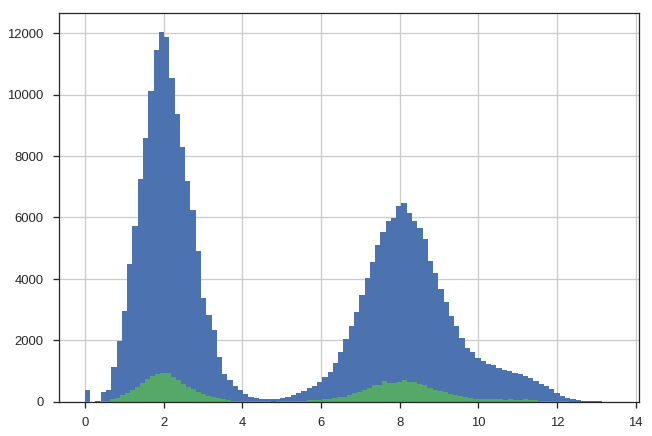

In [24]:
res[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

### Relationship with minimal installment amount and total amount paid over several months.

In [8]:
tmp = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV']]
tmp = tmp.merge(credit_bal.loc[(credit_bal.MONTHS_BALANCE >= -6) & (credit_bal.MONTHS_BALANCE <= -1), :], how='inner')

In [12]:
tmp = tmp.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_TOTAL_CURRENT']]
res = tmp.AMT_PAYMENT_TOTAL_CURRENT - tmp.AMT_INST_MIN_REGULARITY
res = res.groupby(tmp.SK_ID_CURR).mean()

In [14]:
res = app_train.SK_ID_CURR.map(res)
res

0                  NaN
1                  NaN
2                  NaN
3             0.000000
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8             0.000000
9                  NaN
10                 NaN
11                 NaN
12                 NaN
13                 NaN
14                 NaN
15                 NaN
16                 NaN
17            0.000000
18                 NaN
19            0.000000
20                 NaN
21                 NaN
22                 NaN
23                 NaN
24                 NaN
25                 NaN
26                 NaN
27                 NaN
28                 NaN
29                 NaN
              ...     
307481             NaN
307482             NaN
307483             NaN
307484             NaN
307485             NaN
307486             NaN
307487             NaN
307488             NaN
307489     8401.484375
307490             NaN
307491        0.000000
307492             NaN
307493    1

In [15]:
res[res.isnull()].shape[0] / len(res)

0.7465651635226057

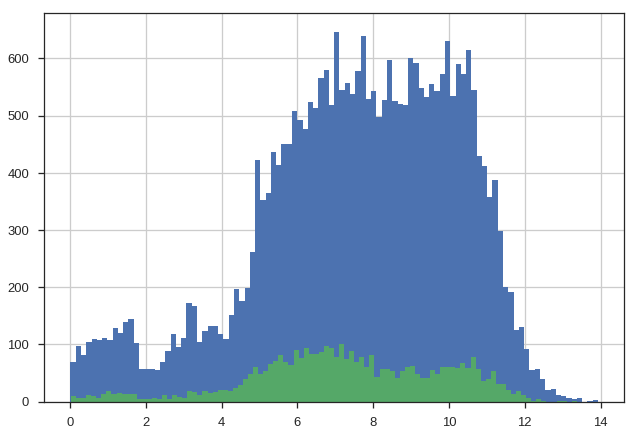

In [19]:
res[(res > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(res > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [29]:
tmp = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV']]
tmp = tmp.merge(credit_bal.loc[(credit_bal.MONTHS_BALANCE >= -6) & (credit_bal.MONTHS_BALANCE <= -1), :], how='inner')

In [30]:
tmp = tmp.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_PAYMENT_TOTAL_CURRENT']]
res = (tmp.AMT_PAYMENT_TOTAL_CURRENT / tmp.AMT_CREDIT_LIMIT_ACTUAL).replace([np.inf, -np.inf], np.nan)
res = res.groupby(tmp.SK_ID_CURR).mean()

res = app_train.SK_ID_CURR.map(res)

In [33]:
res[res.isnull()].shape[0] / len(res)

0.7927358696111684

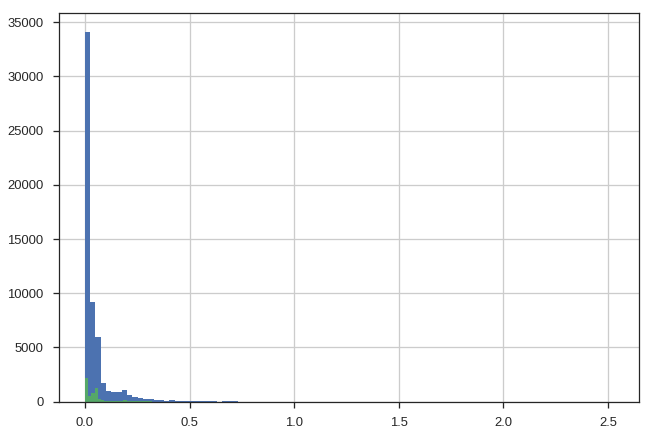

In [32]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

In [6]:
bureau.shape, bureau_bal.shape

((1716428, 17), (27299925, 3))

In [30]:
bureau_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [7]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [61]:
bureau_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [62]:
bureau_bal.STATUS.cat.codes.value_counts()

6    13646993
0     7499507
7     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
dtype: int64

In [57]:
res = bureau_bal.loc[bureau_bal.STATUS.isin(['0', '1', '2', '3', '4', '5'])].groupby('SK_ID_BUREAU').size().reset_index()
res = res.merge(bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']]).drop('SK_ID_BUREAU', axis=1)
res = res.groupby('SK_ID_CURR')[0].sum()
res = app_train.SK_ID_CURR.map(res)

In [58]:
res[res.isnull()].shape[0] / len(res)

0.7077958186861608

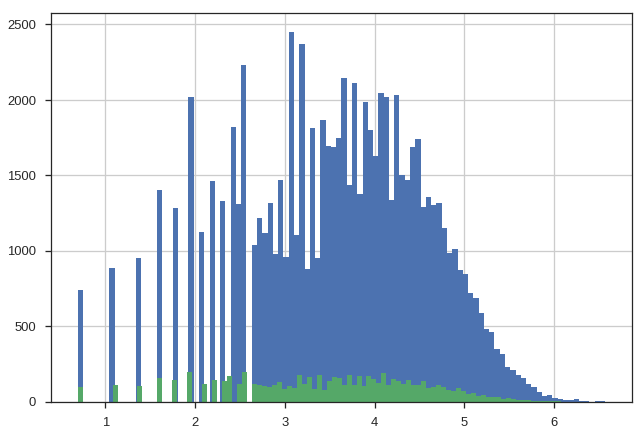

In [60]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

In [4]:
# TARGET == 1
app_train.sample(n=10).SK_ID_CURR

14981     117491
168780    295636
58653     167989
36682     142486
69900     181082
109580    227086
127783    248201
141197    263704
217823    352370
299252    446680
Name: SK_ID_CURR, dtype: int32

In [5]:
prev_app.loc[(prev_app.SK_ID_CURR == 117491)]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
83693,1804158,117491,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,13,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
133896,2502461,117491,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
194299,1204864,117491,Revolving loans,45000.000000,0.0,900000.0,NaN,NaN,WEDNESDAY,16,...,XNA,0.0,XNA,Card X-Sell,-692.0,-651.0,365243.0,365243.0,365243.0,0.0
389221,1622096,117491,Consumer loans,13067.054688,106636.5,117193.5,0.0,106636.5,WEDNESDAY,16,...,Consumer electronics,12.0,high,POS household with interest,365243.0,-1698.0,-1368.0,-1398.0,-1389.0,0.0
777278,1142578,117491,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1088119,2265476,117491,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,14,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1300865,2075947,117491,Consumer loans,40050.898438,230751.0,216585.0,23076.0,230751.0,THURSDAY,14,...,Consumer electronics,6.0,middle,POS household with interest,365243.0,-542.0,-392.0,-392.0,-388.0,0.0


In [9]:
credit_bal.loc[(credit_bal.SK_ID_CURR == 117491) & (credit_bal.SK_ID_PREV == 1204864), :]\
          .sort_values(by='MONTHS_BALANCE', ascending=False).iloc[:, 2:]

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
830720,-1,350736.062500,900000,0.0,132498.0,0.0,132498.0,11070.269531,0.0,0.000000,...,348464.687500,348464.687500,0.0,3,0.0,3.0,21.0,Active,0,0
1149850,-2,197187.031250,900000,0.0,0.0,0.0,0.0,11356.424805,13500.0,2429.729980,...,197187.031250,197187.031250,0.0,0,0.0,0.0,20.0,Active,0,0
3385503,-3,203140.343750,900000,0.0,0.0,0.0,0.0,11639.879883,27000.0,15643.575195,...,203140.343750,203140.343750,0.0,0,0.0,0.0,19.0,Active,0,0
2170242,-4,235741.093750,900000,0.0,0.0,0.0,0.0,11905.469727,13500.0,13500.000000,...,233341.109375,233341.109375,0.0,0,0.0,0.0,18.0,Active,0,0
1511991,-5,241308.578125,900000,0.0,0.0,0.0,0.0,12162.915039,13500.0,13500.000000,...,238868.953125,238868.953125,0.0,0,0.0,0.0,17.0,Active,0,0
296962,-6,246530.156250,900000,0.0,0.0,0.0,0.0,12421.349609,13500.0,13500.000000,...,244050.703125,244050.703125,0.0,0,0.0,0.0,16.0,Active,0,0
2826987,-7,251569.078125,900000,0.0,0.0,0.0,0.0,12662.504883,13500.0,13500.000000,...,249052.500000,249052.500000,0.0,0,0.0,0.0,15.0,Active,0,0
2179598,-8,256656.562500,900000,0.0,0.0,0.0,0.0,12905.730469,13500.0,13500.000000,...,254102.484375,254102.484375,0.0,0,0.0,0.0,14.0,Active,0,0
895364,-9,261379.578125,900000,0.0,0.0,0.0,0.0,13130.910156,13500.0,13500.000000,...,258790.859375,258790.859375,0.0,0,0.0,0.0,13.0,Active,0,0
881786,-10,266156.468750,900000,0.0,0.0,0.0,0.0,13380.344727,13500.0,13500.000000,...,263529.312500,263529.312500,0.0,0,0.0,0.0,12.0,Active,0,0


In [6]:
installments.loc[(installments.SK_ID_CURR == 117491) &\
                 (installments.SK_ID_PREV == 1204864)
                ].sort_values(by='NUM_INSTALMENT_NUMBER').iloc[:, 2:]

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1744564,0.0,1,-651.0,-660.0,12033.855469,12033.855469
3630573,0.0,2,-660.0,-660.0,116.144997,116.144997
1023418,0.0,3,-620.0,-621.0,11832.209961,11832.209961
21553,0.0,4,-621.0,-621.0,1667.790039,1667.790039
1584810,0.0,5,-590.0,-595.0,11552.264648,11552.264648
3484387,0.0,6,-595.0,-595.0,147.735001,147.735001
237955,0.0,7,-559.0,-562.0,11366.099609,11366.099609
551940,0.0,8,-562.0,-562.0,333.899994,333.899994
327489,0.0,9,-529.0,-527.0,14532.839844,14532.839844
2811866,0.0,10,-527.0,-527.0,92.160004,92.160004


In [ ]:
credit_bal.

In [46]:
# balance to amount payment total diff
mask = (credit_bal.MONTHS_BALANCE >= -12) &\
       (credit_bal.MONTHS_BALANCE <= -1) &\
       (credit_bal.NAME_CONTRACT_STATUS == 'Active')

tmp  = credit_bal.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']]
res  = (tmp.AMT_BALANCE - tmp.AMT_PAYMENT_TOTAL_CURRENT)
res  = res.groupby(tmp.SK_ID_CURR).std()
res  = app_train.SK_ID_CURR.map(res)

In [47]:
res[res.isnull()].shape[0] / len(res)

0.7286503572229936

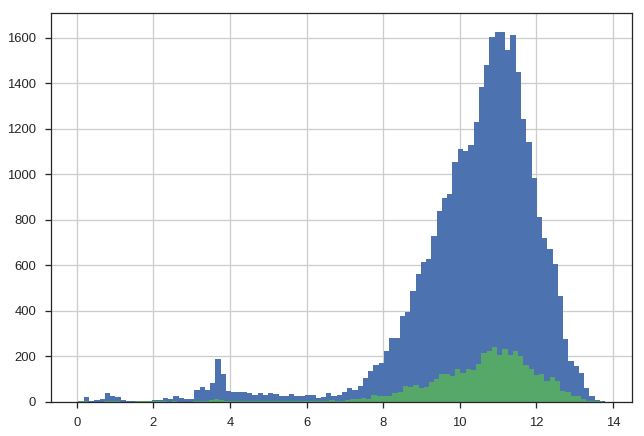

In [49]:
(res[(res > 0) & (app_train.TARGET == 0)]).map(np.log1p).hist(bins=100)
(res[(res > 0) & (app_train.TARGET == 1)]).map(np.log1p).hist(bins=100);

In [44]:
# balance to amount payment total ratio
mask = (credit_bal.MONTHS_BALANCE >= -12) &\
       (credit_bal.MONTHS_BALANCE <= -1) &\
       (credit_bal.NAME_CONTRACT_STATUS == 'Active')

tmp  = credit_bal.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']]
res  = (tmp.AMT_PAYMENT_TOTAL_CURRENT / tmp.AMT_BALANCE).replace([np.inf, -np.inf], np.nan)
res  = res.groupby(tmp.SK_ID_CURR).mean()
res  = app_train.SK_ID_CURR.map(res)

In [45]:
res[res.isnull()].shape[0] / len(res)

0.8759361453736614

### Lowering of credit limit

In [82]:
# sample clients
app_train.sample(n=10).loc[:, ['SK_ID_CURR', 'TARGET']]

,SK_ID_CURR,TARGET
185922,315531,0.0
269575,412407,0.0
242622,380868,0.0
148424,272095,0.0
258605,399275,0.0
205441,338136,0.0
228747,364952,0.0
173345,300878,0.0
175419,303273,0.0
191537,322089,1.0


In [83]:
credit_bal.loc[(credit_bal.SK_ID_CURR == 322089), ]\
          .sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False]).iloc[2:]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3136821,1584886,322089,-3,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
1878095,1584886,322089,-4,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
1032552,1584886,322089,-5,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
356319,1584886,322089,-6,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
3123461,1584886,322089,-7,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
1644620,1584886,322089,-8,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
2814116,1584886,322089,-9,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
999860,1584886,322089,-10,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
3093869,1584886,322089,-11,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
2474696,1584886,322089,-12,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0


In [124]:
rmax = credit_bal.loc[credit_bal.NAME_CONTRACT_STATUS == 'Active', :].groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].max()
rmin = credit_bal.loc[credit_bal.NAME_CONTRACT_STATUS == 'Active', :].groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].min()

rmax = credit_bal.loc[credit_bal.NAME_CONTRACT_STATUS == 'Active', ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]\
               .merge(rmax)
rmin = credit_bal.loc[credit_bal.NAME_CONTRACT_STATUS == 'Active', ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]\
               .merge(rmin)
    
rmax = rmax.set_index(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_CREDIT_LIMIT_ACTUAL']
rmin = rmin.set_index(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_CREDIT_LIMIT_ACTUAL']

res  = (rmin - rmax).reset_index().drop('SK_ID_PREV', axis=1)
res  = res.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].mean()

In [125]:
res  = app_train.SK_ID_CURR.map(res)

In [129]:
res[res.isnull()].shape[0] / len(res)

0.7176101017524577

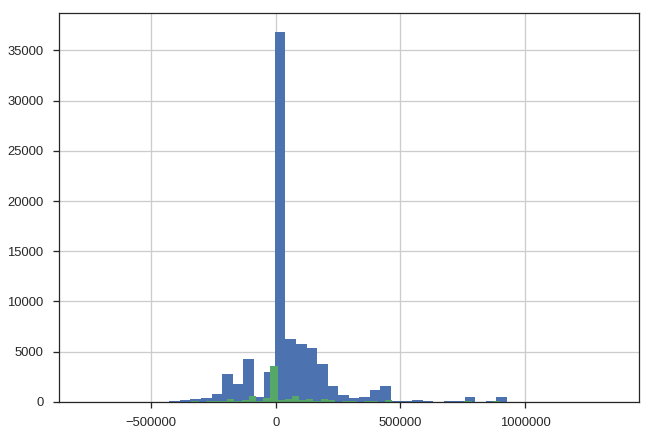

In [135]:
res[app_train.TARGET == 0].hist(bins=50)
res[app_train.TARGET == 1].hist(bins=50);

In [138]:
res[app_train.TARGET == 0].mean(), res[app_train.TARGET == 1].mean()

(46651.13669318741, 30599.282773276664)

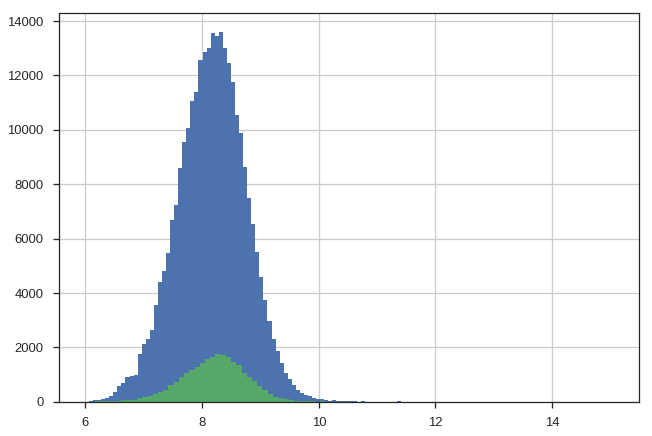

In [11]:
(app_train.AMT_INCOME_TOTAL / (-app_train.DAYS_BIRTH / 365)).map(lambda x : np.log(x + 1))[app_train.TARGET == 0].hist(bins=100)
(app_train.AMT_INCOME_TOTAL / (-app_train.DAYS_BIRTH / 365)).map(lambda x : np.log(x + 1))[app_train.TARGET == 1].hist(bins=100);

### Loan Stacking

In [8]:
res = app_train.loc[:, ['SK_ID_CURR']]\
         .merge(bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'SK_ID_BUREAU']], how='left')
    
print('Percentage of clients with data in bureau: {}'.format(res[res.SK_ID_BUREAU.notnull()].shape[0] / len(res)))

Percentage of clients with data in bureau: 0.8570870500411211


In [20]:
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') &\
           (bureau.DAYS_CREDIT > -400)
           , ['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']]\
      .groupby('SK_ID_CURR').size()
res = app_train.SK_ID_CURR.map(res)
print(res[res.isnull()].shape[0] / len(res))

0.5269307439408671


In [21]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET        0.0   1.0     ratio
SK_ID_CURR                       
1.0         78750  6698  0.078387
2.0         35020  3848  0.099002
3.0         12277  1772  0.126130
4.0          3969   768  0.162128
5.0          1294   300  0.188206
6.0           380   128  0.251969
7.0           118    45  0.276074
8.0            44    20  0.312500
9.0            16     5  0.238095
10.0            3     8  0.727273
11.0            2     2  0.500000
12.0            2     2  0.500000
13.0            1     0  0.000000
14.0            1     0  0.000000
16.0            0     1  1.000000


In [43]:
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') &\
           (bureau.DAYS_CREDIT > -400) &\
           (bureau.DAYS_CREDIT_ENDDATE > 0)
           , ['SK_ID_CURR', 'SK_ID_BUREAU', 
              'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 
              'AMT_CREDIT_SUM']]
res.loc[:, 'duration'] = res.DAYS_CREDIT_ENDDATE - res.DAYS_CREDIT
res = res.groupby('SK_ID_CURR')['duration'].min()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.5605620611945589


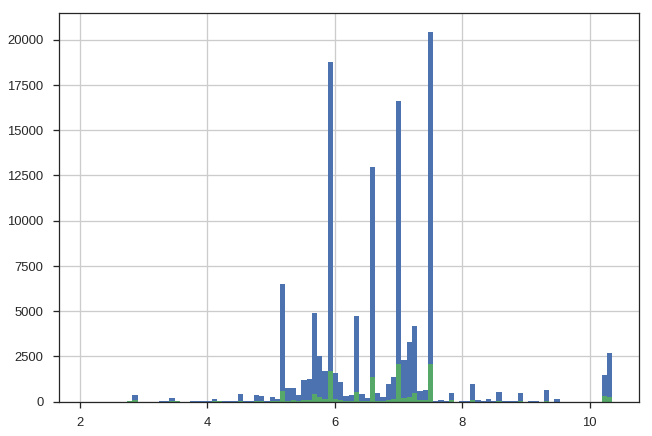

In [47]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

In [41]:
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') &\
           (bureau.DAYS_CREDIT > -400) &\
           (bureau.DAYS_CREDIT_ENDDATE > 0)
           , ['SK_ID_CURR', 'SK_ID_BUREAU', 
              'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 
              'AMT_CREDIT_SUM']]
res.loc[:, 'duration'] = res.DAYS_CREDIT_ENDDATE - res.DAYS_CREDIT
res.loc[:, 'credit_by_duration'] = res.AMT_CREDIT_SUM / res.duration
res = res.groupby('SK_ID_CURR')['credit_by_duration'].min()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.5605620611945589


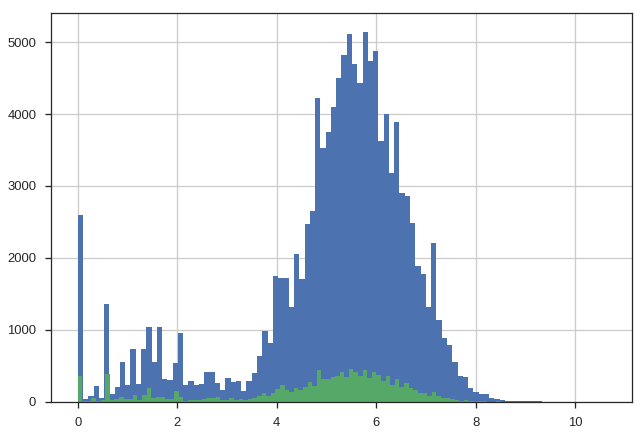

In [42]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

In [52]:
# number of null external scores
res = app_train.EXT_SOURCE_1.isnull().astype(np.uint8) +\
      app_train.EXT_SOURCE_2.isnull().astype(np.uint8) +\
      app_train.EXT_SOURCE_3.isnull().astype(np.uint8)
        
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET     0.0    1.0     ratio
row_0                          
0       101591   7998  0.072982
1       147845  13168  0.081782
2        33092   3645  0.099219
3          158     14  0.081395


### Type of loans

In [5]:
app_train.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

** Most of the loans are cash loans, very few are revolving loans. **

In [6]:
ss = pd.crosstab(app_train.NAME_CONTRACT_TYPE, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET                 0.0    1.0     ratio
NAME_CONTRACT_TYPE                         
Cash loans          255011  23221  0.083459
Revolving loans      27675   1604  0.054783


In [18]:
# how many of people whose current application is of cash loan
# have information report coming from bureau.

res = app_train.loc[app_train.NAME_CONTRACT_TYPE == 'Cash loans', ['SK_ID_CURR']]\
               .merge(bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']], how='left')
res[res.SK_ID_BUREAU.isnull()].shape[0] / len(res)

0.028647453326083015

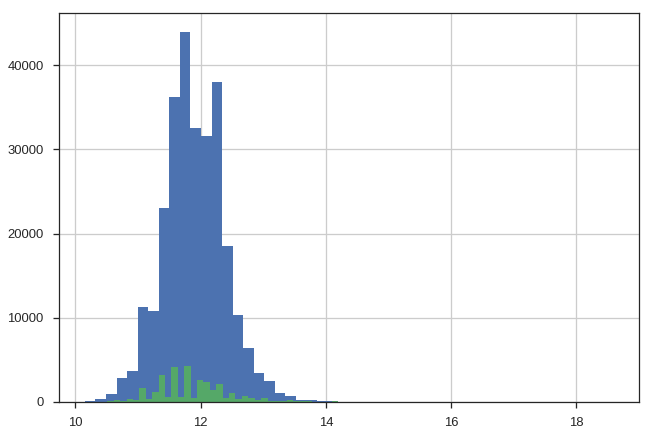

In [9]:
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Cash loans'), 'AMT_INCOME_TOTAL'].map(np.log1p).hist(bins=50)
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Revolving loans'), 'AMT_INCOME_TOTAL'].map(np.log1p).hist(bins=50);

### Amount of credit

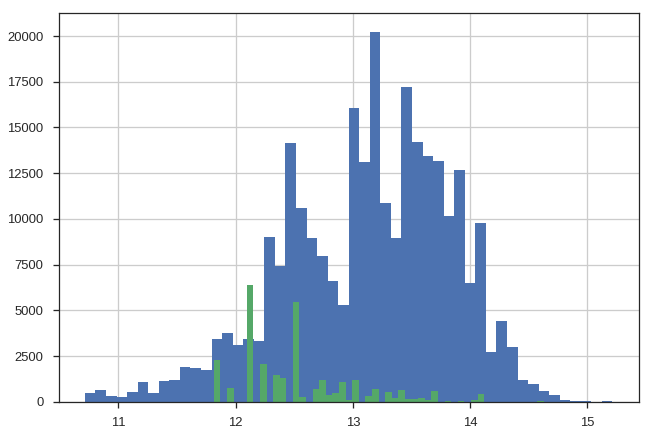

In [10]:
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Cash loans'), 'AMT_CREDIT'].map(np.log1p).hist(bins=50)
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Revolving loans'), 'AMT_CREDIT'].map(np.log1p).hist(bins=50);

### Age

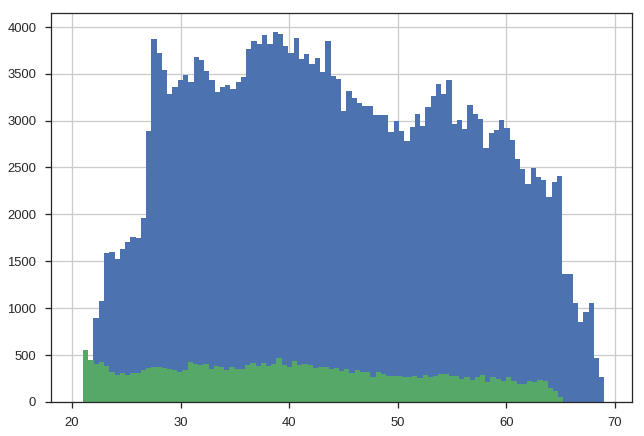

In [12]:
(-app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Cash loans'), 'DAYS_BIRTH'] / 365).hist(bins=100)
(-app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Revolving loans'), 'DAYS_BIRTH'] / 365).hist(bins=100);

### Days Employed

365243 is used as nan value

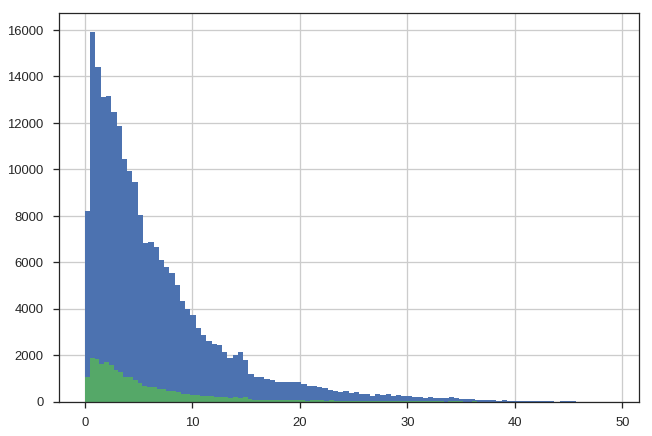

In [15]:
(-app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Cash loans') &\
                (app_train.DAYS_EMPLOYED != 365243)
                , 'DAYS_EMPLOYED'] / 365).hist(bins=100)
(-app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Revolving loans') &\
                (app_train.DAYS_EMPLOYED != 365243), 'DAYS_EMPLOYED'] / 365).hist(bins=100);

### Amount goods price

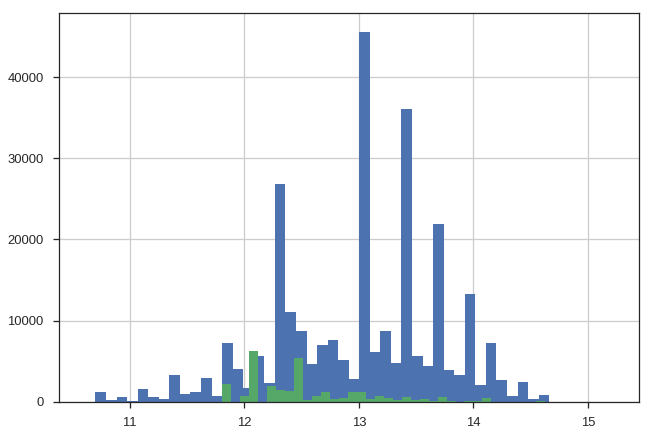

In [19]:
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Cash loans'), 'AMT_GOODS_PRICE'].map(np.log1p).hist(bins=50)
app_train.loc[(app_train.NAME_CONTRACT_TYPE == 'Revolving loans'), 'AMT_GOODS_PRICE'].map(np.log1p).hist(bins=50);

### Relationship between credit amount and goods price against which loan was given

In [36]:
prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
             ((prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull()))
             , ['SK_ID_CURR',
               'SK_ID_PREV',
               'AMT_CREDIT',
               'AMT_GOODS_PRICE',
               'DAYS_TERMINATION',
               'NAME_CONTRACT_TYPE'
              ]].head(6)

,SK_ID_CURR,SK_ID_PREV,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_TERMINATION,NAME_CONTRACT_TYPE
1,108129,2802425,679671.0,607500.0,365243.0,Cash loans
2,122040,2523466,136444.5,112500.0,365243.0,Cash loans
17,142748,1285768,180000.0,180000.0,365243.0,Revolving loans
18,396305,2393109,180000.0,180000.0,NaN,Cash loans
21,267782,1182516,451777.5,405000.0,365243.0,Cash loans
34,255331,1629736,202500.0,202500.0,365243.0,Revolving loans


In [50]:
res = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
             ((prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull()))
             , ['SK_ID_CURR',
               'SK_ID_PREV',
               'AMT_CREDIT',
               'AMT_GOODS_PRICE',
               'DAYS_TERMINATION',
               'NAME_CONTRACT_TYPE'
              ]]

tmp = (res.AMT_CREDIT / res.AMT_GOODS_PRICE).replace([np.inf, -np.inf], np.nan)
tmp = tmp.groupby(res.SK_ID_CURR).min()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.5317858548149497

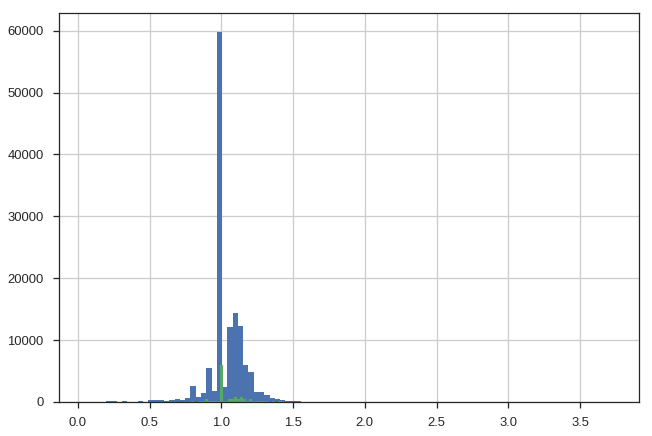

In [51]:
tmp[app_train.TARGET == 0].hist(bins=100)
tmp[app_train.TARGET == 1].hist(bins=100);

### Grouped interest rate of previous applications

In [78]:
res = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
             ((prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull()))
             , ['SK_ID_CURR',
               'SK_ID_PREV',
               'NAME_YIELD_GROUP'
              ]]

res = res.groupby(['SK_ID_CURR', 'NAME_YIELD_GROUP']).size().unstack().fillna(0).astype(np.int8)
res = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(res, left_on='SK_ID_CURR', right_index=True, how='left').fillna(0)
res.iloc[:, 2:] = res.iloc[:, 2:].astype(np.int8)

In [87]:
ss = pd.crosstab(res.XNA.astype(np.str) + '_' + res.high.astype(np.str) + '_' + , res.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET     0.0    1.0     ratio
row_0                          
0_0     205635  16717  0.075183
0_1      12179   1473  0.107896
0_2        717    100  0.122399
0_3         61      9  0.128571
0_4          8      1  0.111111
0_5          0      1  1.000000
1_0      58487   5793  0.090121
1_1       4283    557  0.115083
1_2        321     41  0.113260
1_3         18      2  0.100000
1_4          2      1  0.333333
1_5          2      0  0.000000
2_0        822    102  0.110390
2_1         93     19  0.169643
2_2         11      6  0.352941
2_4          1      0  0.000000
3_0         42      3  0.066667
3_3          1      0  0.000000
4_0          3      0  0.000000


In [100]:
prev_app.NAME_YIELD_GROUP.value_counts()

XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_GROUP, dtype: int64

In [107]:
prev_app.NAME_YIELD_GROUP.cat.codes.value_counts()

0    517215
4    385532
1    353331
3    322095
2     92041
dtype: int64

In [105]:
res = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   ((prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull())) &\
                   (prev_app.NAME_YIELD_GROUP.isin(['high', 'XNA']) )
             , ['SK_ID_CURR'
              ]]
res = res.groupby(['SK_ID_CURR']).size()
res = app_train.SK_ID_CURR.map(res)

res[res.isnull()].shape[0] / len(res)

0.7230700690381807

In [106]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

TARGET        0.0   1.0     ratio
SK_ID_CURR                       
1.0         70666  7266  0.093235
2.0          5822   759  0.115332
3.0           517    72  0.122241
4.0            40     9  0.183673
5.0             2     2  0.500000
6.0             4     0  0.000000


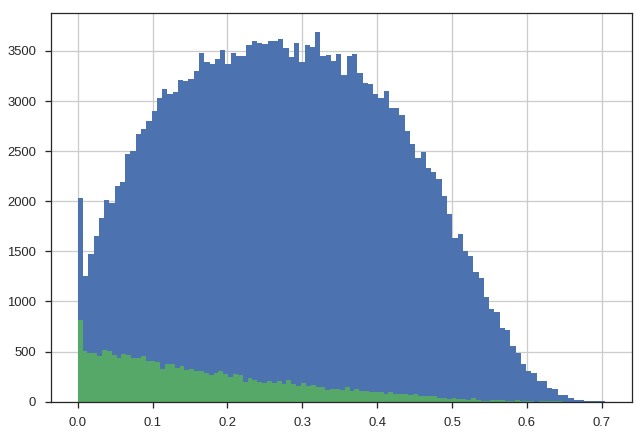

In [119]:
(app_train.EXT_SOURCE_2 * app_train.EXT_SOURCE_3)[(app_train.TARGET == 0)].hist(bins=100)
(app_train.EXT_SOURCE_2 * app_train.EXT_SOURCE_3)[(app_train.TARGET == 1)].hist(bins=100);

In [113]:
app_train[app_train.EXT_SOURCE_2.isnull()].shape[0] / len(app_train)

0.0021462646864665006

In [114]:
app_train[app_train.EXT_SOURCE_3.isnull()].shape[0] / len(app_train)

0.19825307062186392